[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/monte-flora/explain_tutorial/blob/main/src/tutorial_notebooks/Notebook02_Explainability_Tutorial.ipynb)



### Explanability Tutorial 

This notebook will demonstrate how to use scikit-explain to compute and visualize explainability output. 
The first section is based on comparing SHAP and SAGE values for individual features. The second section is the learned effect plots and the final section are the grouped SHAP and SAGE values. 

As discussed in the [Chase et al.](https://github.com/ai2es/WAF_ML_Tutorial_Part1/blob/main/jupyter_notebooks/Notebook01_Explore_SEVIR.ipynb) tutorial package, it is crucial that users and developers have a nuanced understanding of the data before training an ML model. This is especially true before attempting to understand an ML model trained on that data. For this tutorial, we primarily focus on the frozen road surface dataset ([Handler et al. 2020](https://journals.ametsoc.org/view/journals/wefo/35/5/wafD190159.xml)), but there are two other datasets available to explore (severe wind: [Flora et al. 2021](https://journals.ametsoc.org/view/journals/mwre/149/5/MWR-D-20-0194.1.xml); lighting: [Chase et al. 2022](https://journals.ametsoc.org/view/journals/wefo/37/8/WAF-D-22-0070.1.xml)). We recommend reading over these articles for a fuller understanding of the respective datasets and the prediction task. 


<div class="alert alert-block alert-warning"><b>Warning: </b> This notebook will only execute once you've generated the explanation output from Notebook01_Generate_Explanations</div>

#### Import python packages (internal and third party)

<div class="alert alert-block alert-warning"><b>Reminder: </b> To explore the other models/datasets, change the dataset variable below ('road_surface', 'severe_wind', 'lightning'). Reminder that you must run Notebook01_Generate_Explanations with that dataset first!</div>

In [1]:
import os
# Set this user paths for where you stored the models and the datasets. 
DATASET         = 'road_surface'
BASE_PATH       = os.getcwd()
RESULTS_PATH    = os.path.join(BASE_PATH, 'results')
DATA_BASE_PATH  = os.path.join(BASE_PATH, 'datasets')
MODEL_BASE_PATH = os.path.join(BASE_PATH, 'models')

In [2]:
def using_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if not using_colab():
    # Check for the 'results' dir
    import os
    if not os.path.exists('results'):
        raise FileNotFoundError('Must run Notebook01_Generate_Explanations to execute this notebook!')

In [3]:
# Neccesary packages to load the ML models from pickle
%pip install scikit-explain==0.1.4 sage-importance imblearn daal4py scikit-learn==1.0.2 netCDF4 scikit-learn-intelex bayeshist

In [4]:
import sys, os
if using_colab():
    # When using Google Colab, need to clone the explain_tutorial repo
    # Otherwise, the code assumes you are running these notebooks
    # in their original directory structure. 
    !git clone https://github.com/monte-flora/explain_tutorial
    sys.path.append('/content/explain_tutorial/')  
    from src.io.colab_io import GoogleDriveIO
else:
    from os.path import dirname
    path = dirname(dirname(os.getcwd()))
    sys.path.append(path)    

# Internal packages 
from src.io.io import load_data_and_model
from src.io.display_names import feature_colors, display_feature_names, display_units

    
# Download data from Google drive
if using_colab():
    DATASET_PATHS = {'lightning' : '/content/datasets/lightning_dataset.csv', 
              'road_surface' : '/content/datasets/road_surface_dataset.csv', 
              'severe_wind' : '/content/datasets/severe_wind_dataset.csv', 
     }
    MODEL_PATHS = {                  
              'lightning' : '/content/models/NN_classification.joblib', 
              'road_surface' : '/content/models/JTTI_ProbSR_RandomForest.pkl', 
              'severe_wind' : '/content/models/LogisticRegression_wind_severe_0km_None_first_hour_realtime.joblib', 
              }
    RESULTS_PATHS = {                  
                  f'ale_{DATASET}' : f'/content/results/ale_{DATASET}.nc', 
                  f'shap_{DATASET}' : f'/content/results/shap_{DATASET}.nc', 
                  f'shap_rank_{DATASET}' : f'/content/results/shap_rank_{DATASET}.nc', 
                  f'grouped_sage_{DATASET}' : f'/content/results/grouped_sage_{DATASET}.nc', 
                  f'sage_{DATASET}' : f'/content/results/sage_{DATASET}.nc',  
              }
    
    paths_dict = {f'{DATASET} dataset' :  DATASET_PATHS[DATASET], 
                  f'{DATASET} model' :  MODEL_PATHS[DATASET], 
                  }
    
    paths_dict = {**paths_dict, **RESULTS_PATHS}
    
    downloader = GoogleDriveIO()
    # Make a 'datasets' and 'models' directories
    if not os.path.exists('datasets'):
        os.mkdir('datasets')
    if not os.path.exists('models'):
        os.mkdir('models')

    for title in paths_dict.keys():
        downloader.download(title, paths_dict[title])

In [5]:
# Scikit-Explain 
import skexplain 
from skexplain.common.importance_utils import to_skexplain_importance
from skexplain.common.contrib_utils import group_local_values, group_feature_values
from skexplain.plot.plot_feature_contributions import add_summary_plot_cb
from skexplain.plot.base_plotting import PlotStructure
from bayeshist import bayesian_histogram, plot_bayesian_histogram

# Third party packages 
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Load the ML data and Datasets 

In [6]:
model, X, y, groups = load_data_and_model(DATASET, DATA_BASE_PATH, MODEL_BASE_PATH, return_groups=True)

### Visualize the Features 

In this section, we can plot the distribution of values for different features. Getting a sense for the skewedness, the range of values, etc helps us better understand the data.  Plotting the data can also expose issues with the data.

Surface temperature and 2-m temperature are fairly similar and both normally distributed. The surface temperature is also identically distributed as the outgoing longwave radiation ($\lambda$). Surface temperature is partially derived for the radiation scheme in the High-Resolution Rapid Refresh (HRRR) model, so the identical distributions is unsurprising. Knowing these details can help us interpret the explainability results below. 


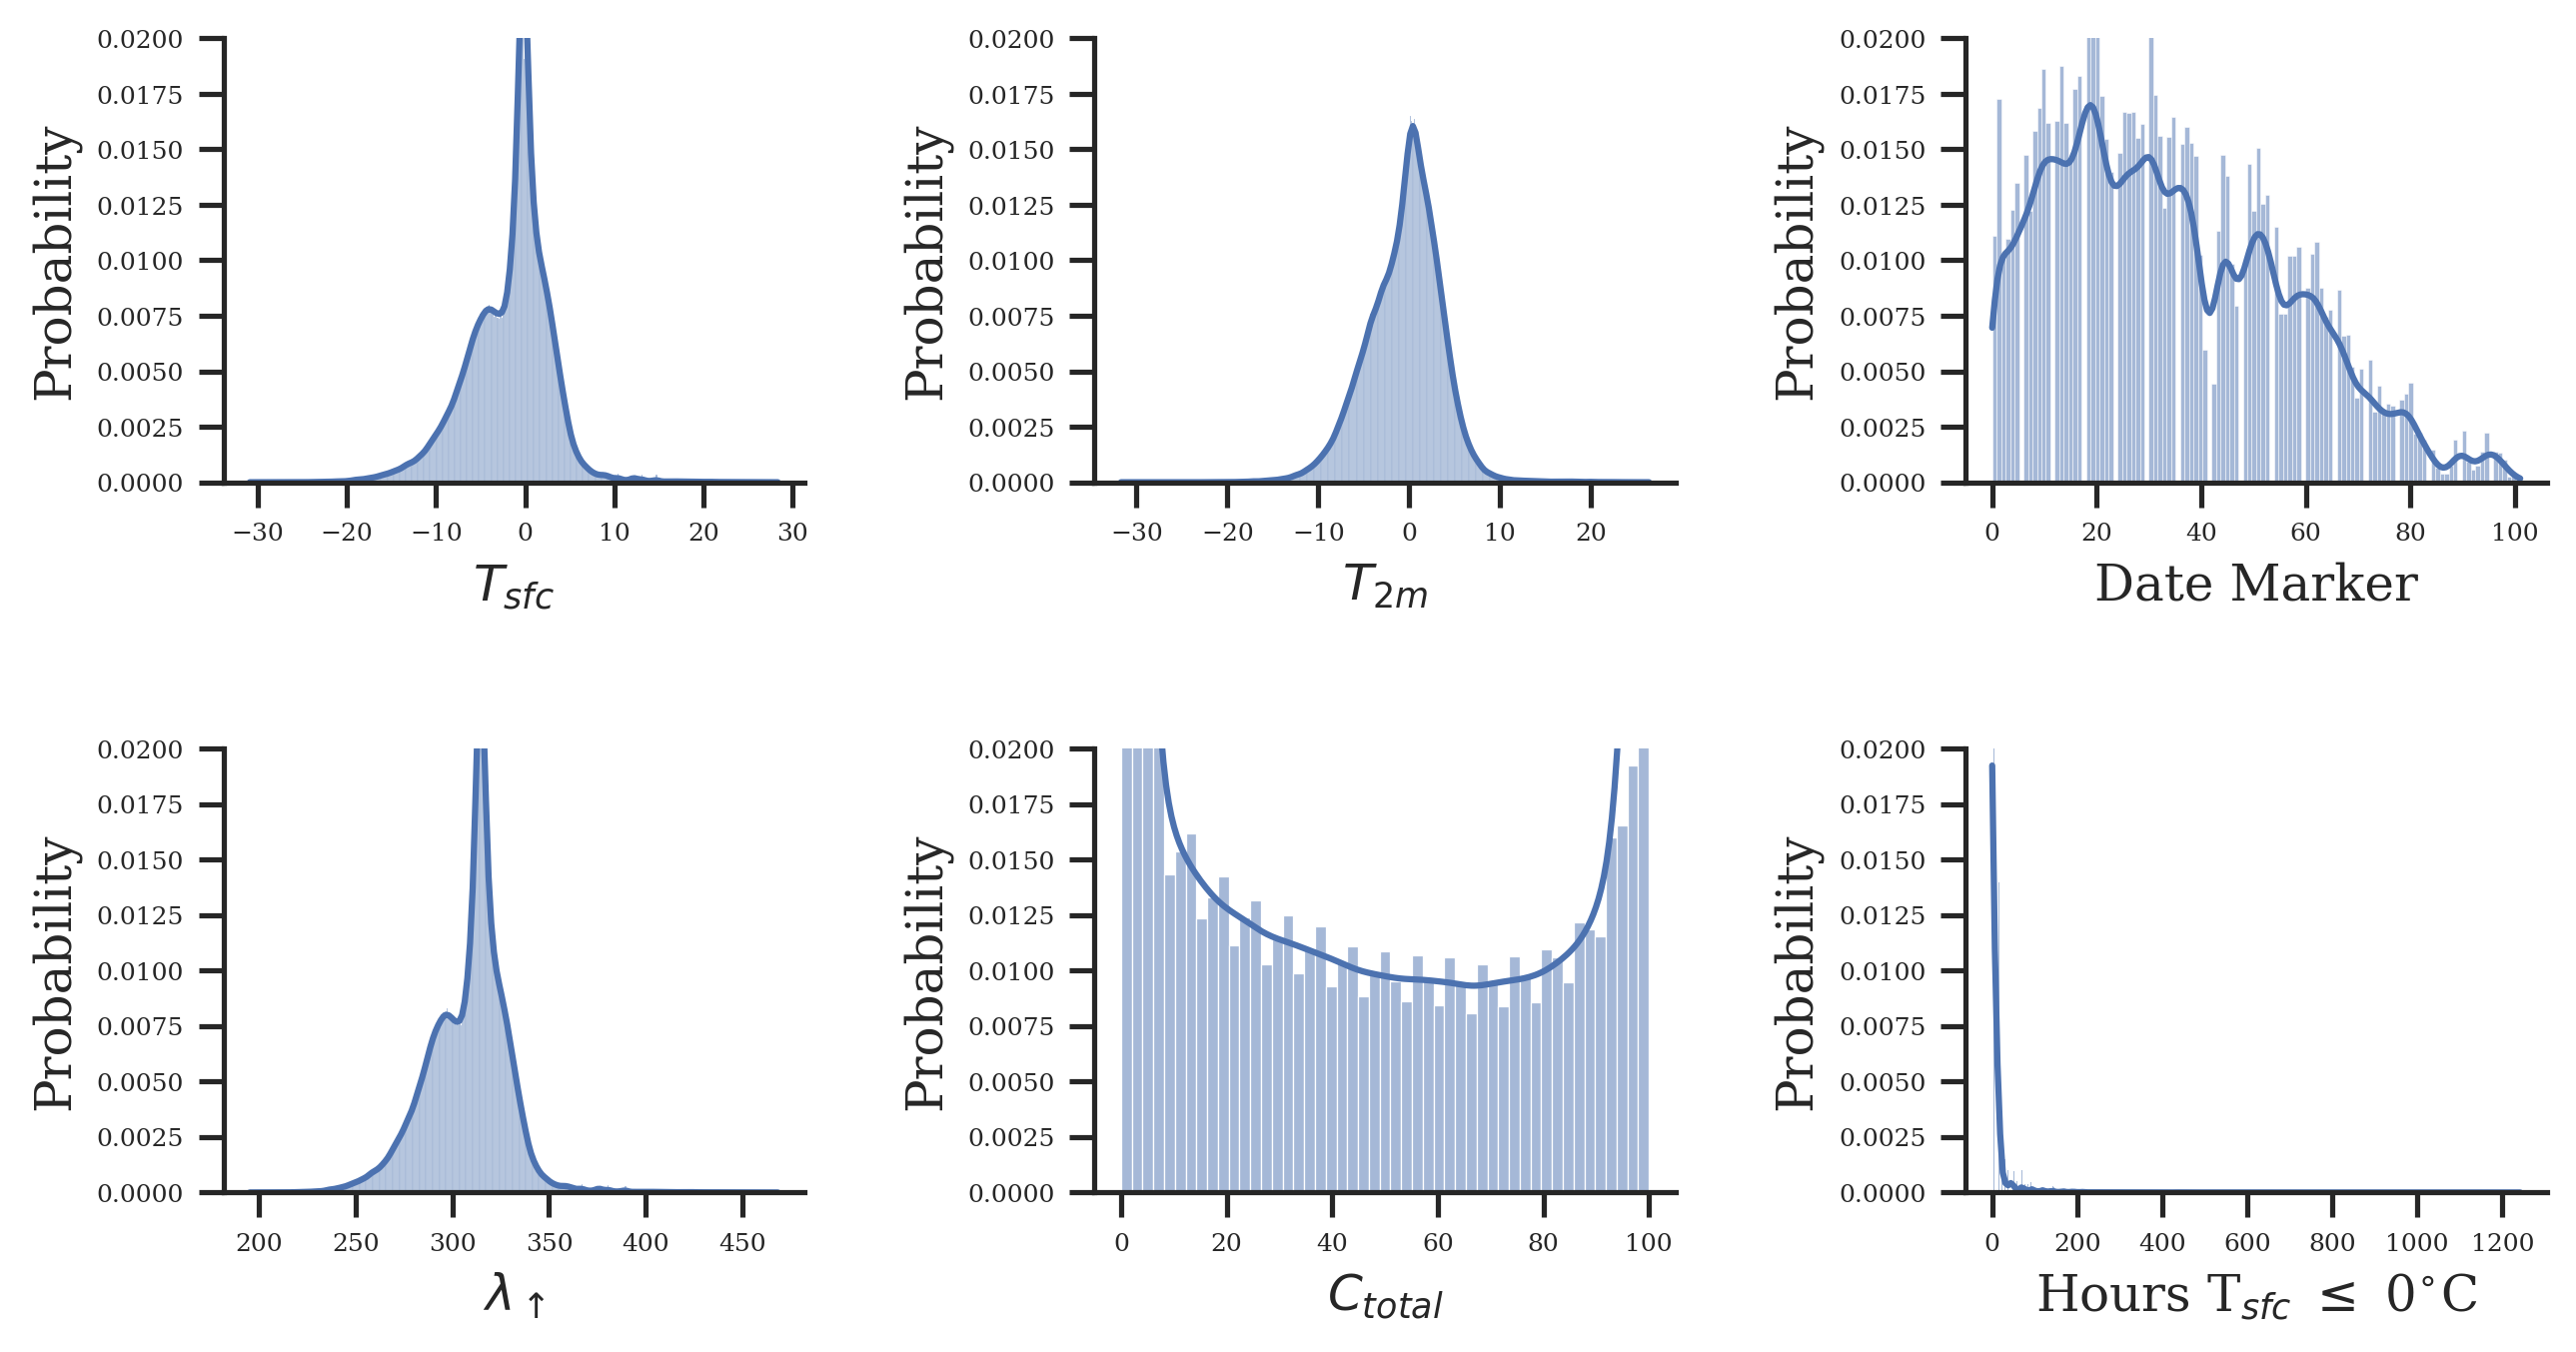

In [7]:
# These variables only work for the road surface dataset. 
# We strongly encourage exploring the variables of the other datasets
variables = ['sfc_temp', 'temp2m', 'date_marker', 'uplwav_flux', 'tot_cloud', 'sfcT_hrs_bl_frez']

# Create a plotting panels. 
fig, axes =plt.subplots(dpi=300, ncols=3, nrows=2, figsize=(10,5))

# The dataset has 2.7 million examples. To reduce the dataset for plotting purposes, 
# we can subsample the data. In this example, I'm taking a random 50K examples.
inds = np.random.choice(X.shape[0], 500000, replace=False)
X_sub = X.iloc[inds]
X_sub.reset_index(drop=True, inplace=True)

# This is main plotting code. We are using the histplot for the seaborn package. 
for i, (v, ax) in enumerate(zip(variables, axes.flat)):
    sns.histplot(data=X_sub, x=v, ax=ax, kde=True, stat='probability')
    ax.set_xlabel(display_feature_names.get(v,v))
    ax.set_ylim([0, 0.02])
    
plt.subplots_adjust(wspace=0.5, hspace=0.6) 

### Load the SHAP and ALE results

In [9]:
shap_ds = xr.load_dataset(os.path.join(RESULTS_PATH, f'shap_{DATASET}.nc'))
ale_data = xr.load_dataset(os.path.join(RESULTS_PATH, f'ale_{DATASET}.nc'))
sage_rank = xr.load_dataset(os.path.join(RESULTS_PATH, f'sage_{DATASET}.nc'))

shap_df = pd.DataFrame(shap_ds[f'shap_values__{model[0]}'], columns=shap_ds.attrs['features'])

X = pd.DataFrame(shap_ds['X'].values, columns=shap_ds.attrs['features'])
y = shap_ds['y'].values

### SHAP and SAGE Comparison 

The SHAP and SAGE feature rankings for the road surface dataset are shown in Figure below. This figure displays features ranked by their mean absolute SHAP value. Each feature is represented by a scatter plot color-coded by the normalized feature value, and density can be approximated by vertical dispersion. This plot allows a more comprehensive interpretation of feature rank and effect. For example, $T_{sfc}$ SHAP values display a bi-modal distribution, with negative values for low temperatures and positive values for moderate to high temperatures, with a sparse density in between. We interpret SHAP values in the following way: an increase or decrease in the model prediction as compared to the global average model prediction. For example, a cold surface temperature can increase the probability of a freezing road surface by 10-15$\%$, but that is given the static base rate of 40$\%$. We interpret the SAGE values in a similar way: the decrease or increase in model performance as compared to model performance when only predicting the base rate. If the model is near-optimal model (i.e., a Bayesian classifier), then we can interpert SAGE values as conditional mutual information or how informative a feature is of the target variable given the other features in the dataset. 


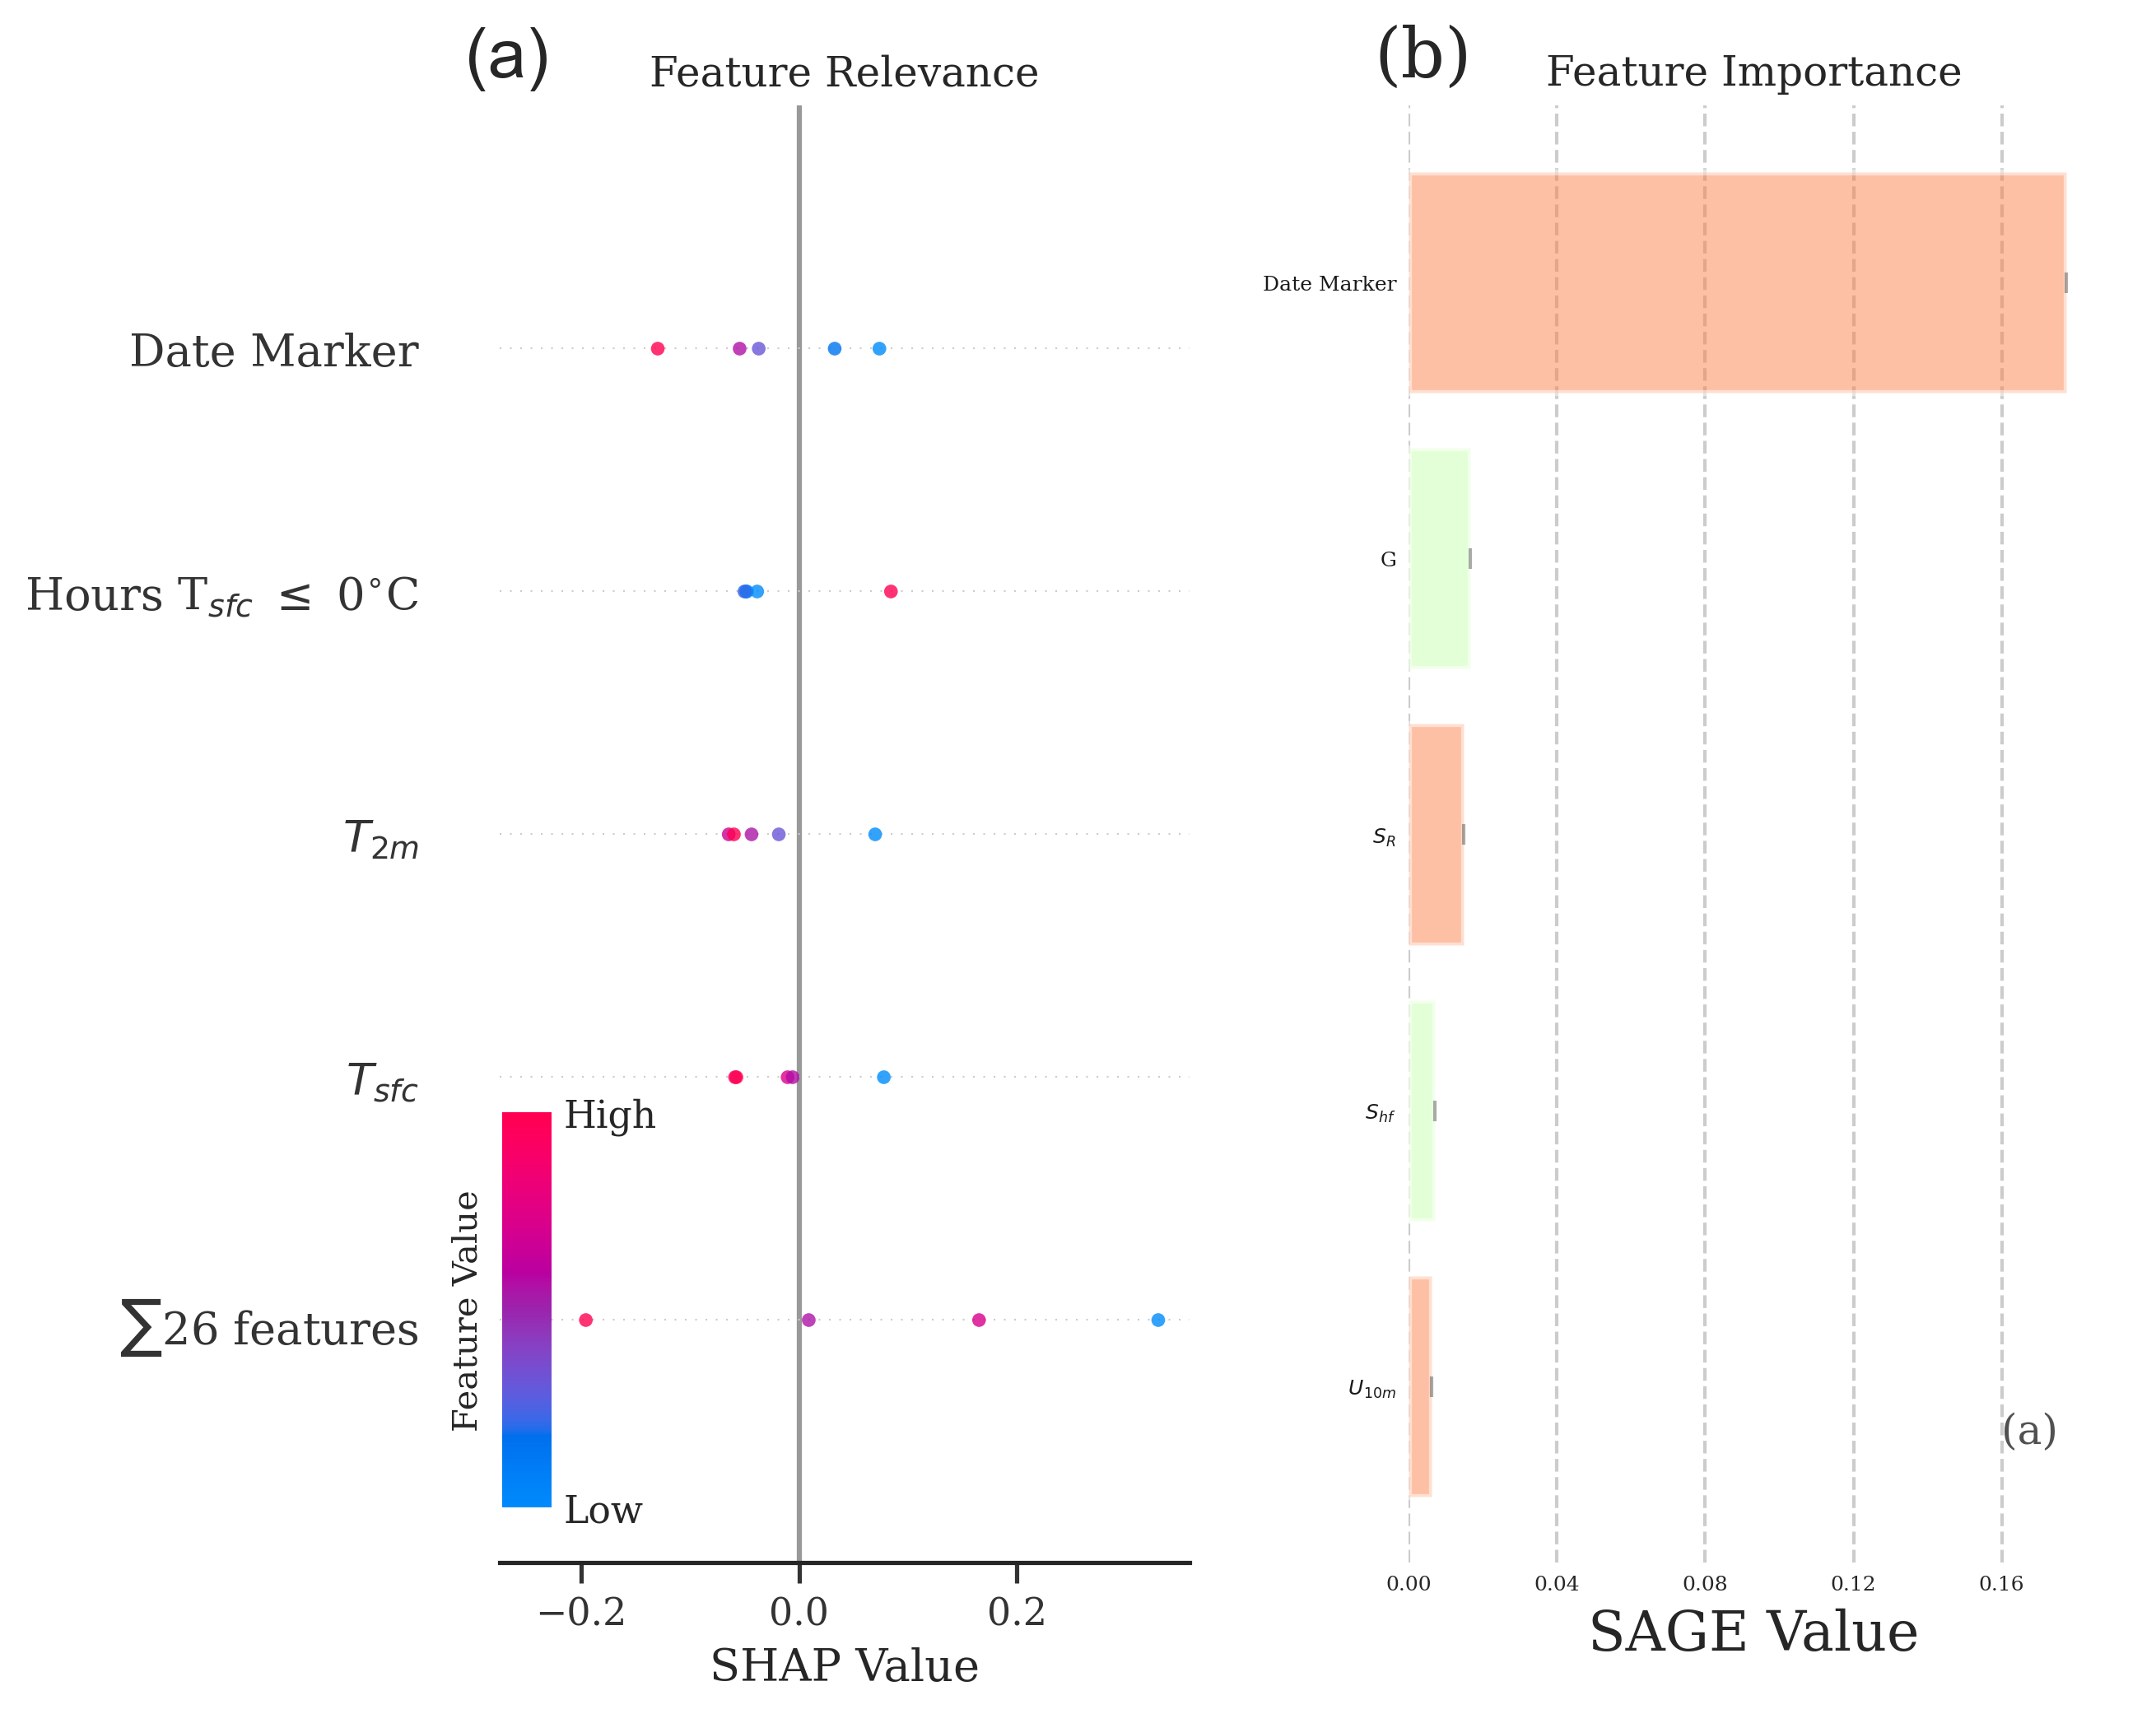

In [10]:
fig, axes = plt.subplots(dpi=300, ncols=2, figsize=(10,8))

# Initialize the scikit-explain explainer. 
explainer = skexplain.ExplainToolkit(X=X)

# Rank the SHAP values by the mean absolute values. 
est_name = model[0]
vals = shap_ds[f'shap_values__{est_name}'].values
order = np.argsort(np.mean(np.absolute(vals), axis=0))[::-1]

# Left panel: SHAP 
ax, color = explainer.scatter_plot(plot_type='summary', 
                       dataset=shap_ds, 
                       estimator_name=model[0], method='shap',
                       order=order, 
                       display_feature_names=display_feature_names,
                       ax=axes[0],
                       fig=fig,
                       add_colorbar=False,
                       max_display=len(X)
                      )

ax.set_xlabel('SHAP Value')
ax.set_title('Feature Relevance', fontsize=12)
ax.annotate('(a)', (-0.05, 1.02), xycoords='axes fraction', fontsize=20)

# Right panel: SAGE
data = [sage_rank]
panels = [ ('sage', est_name)]
explainer.plot_importance(data=data, panels=panels, 
                                num_vars_to_plot=len(X), 
                                feature_colors=feature_colors,
                                display_feature_names=display_feature_names,
                                n_columns=1,
                                base_font_size= 18,
                                alphabet_fontsize=12, 
                                rho_threshold=0.7,
                                xlabels=['SAGE Value'],
                                ax=axes[1], 
                               )
axes[1].xaxis.grid(ls='dashed')
axes[1].set_title('Feature Importance', fontsize=12)
axes[1].annotate('(b)', (-0.05, 1.02), xycoords='axes fraction', fontsize=20)

# Add colorbar to the left panel for the normalized feature value range. 
cb = add_summary_plot_cb(color, cax=axes[0], orientation='vertical', 
                        fig=fig, ax_dim=[0.3, 0.2, 0.02, 0.2], fontsize=10, 
                         labelpad=-60, y = 0.5,
                        )

### Grouped SHAP vs. Grouped SAGE 

This figure is similar to figure above, but instead of analyzing individual features, we group the SAGE and SHAP values by feature grouping. When features are physically correlated or naturally grouped together, this approach can provide clearer insight into the inner workings of the model. 


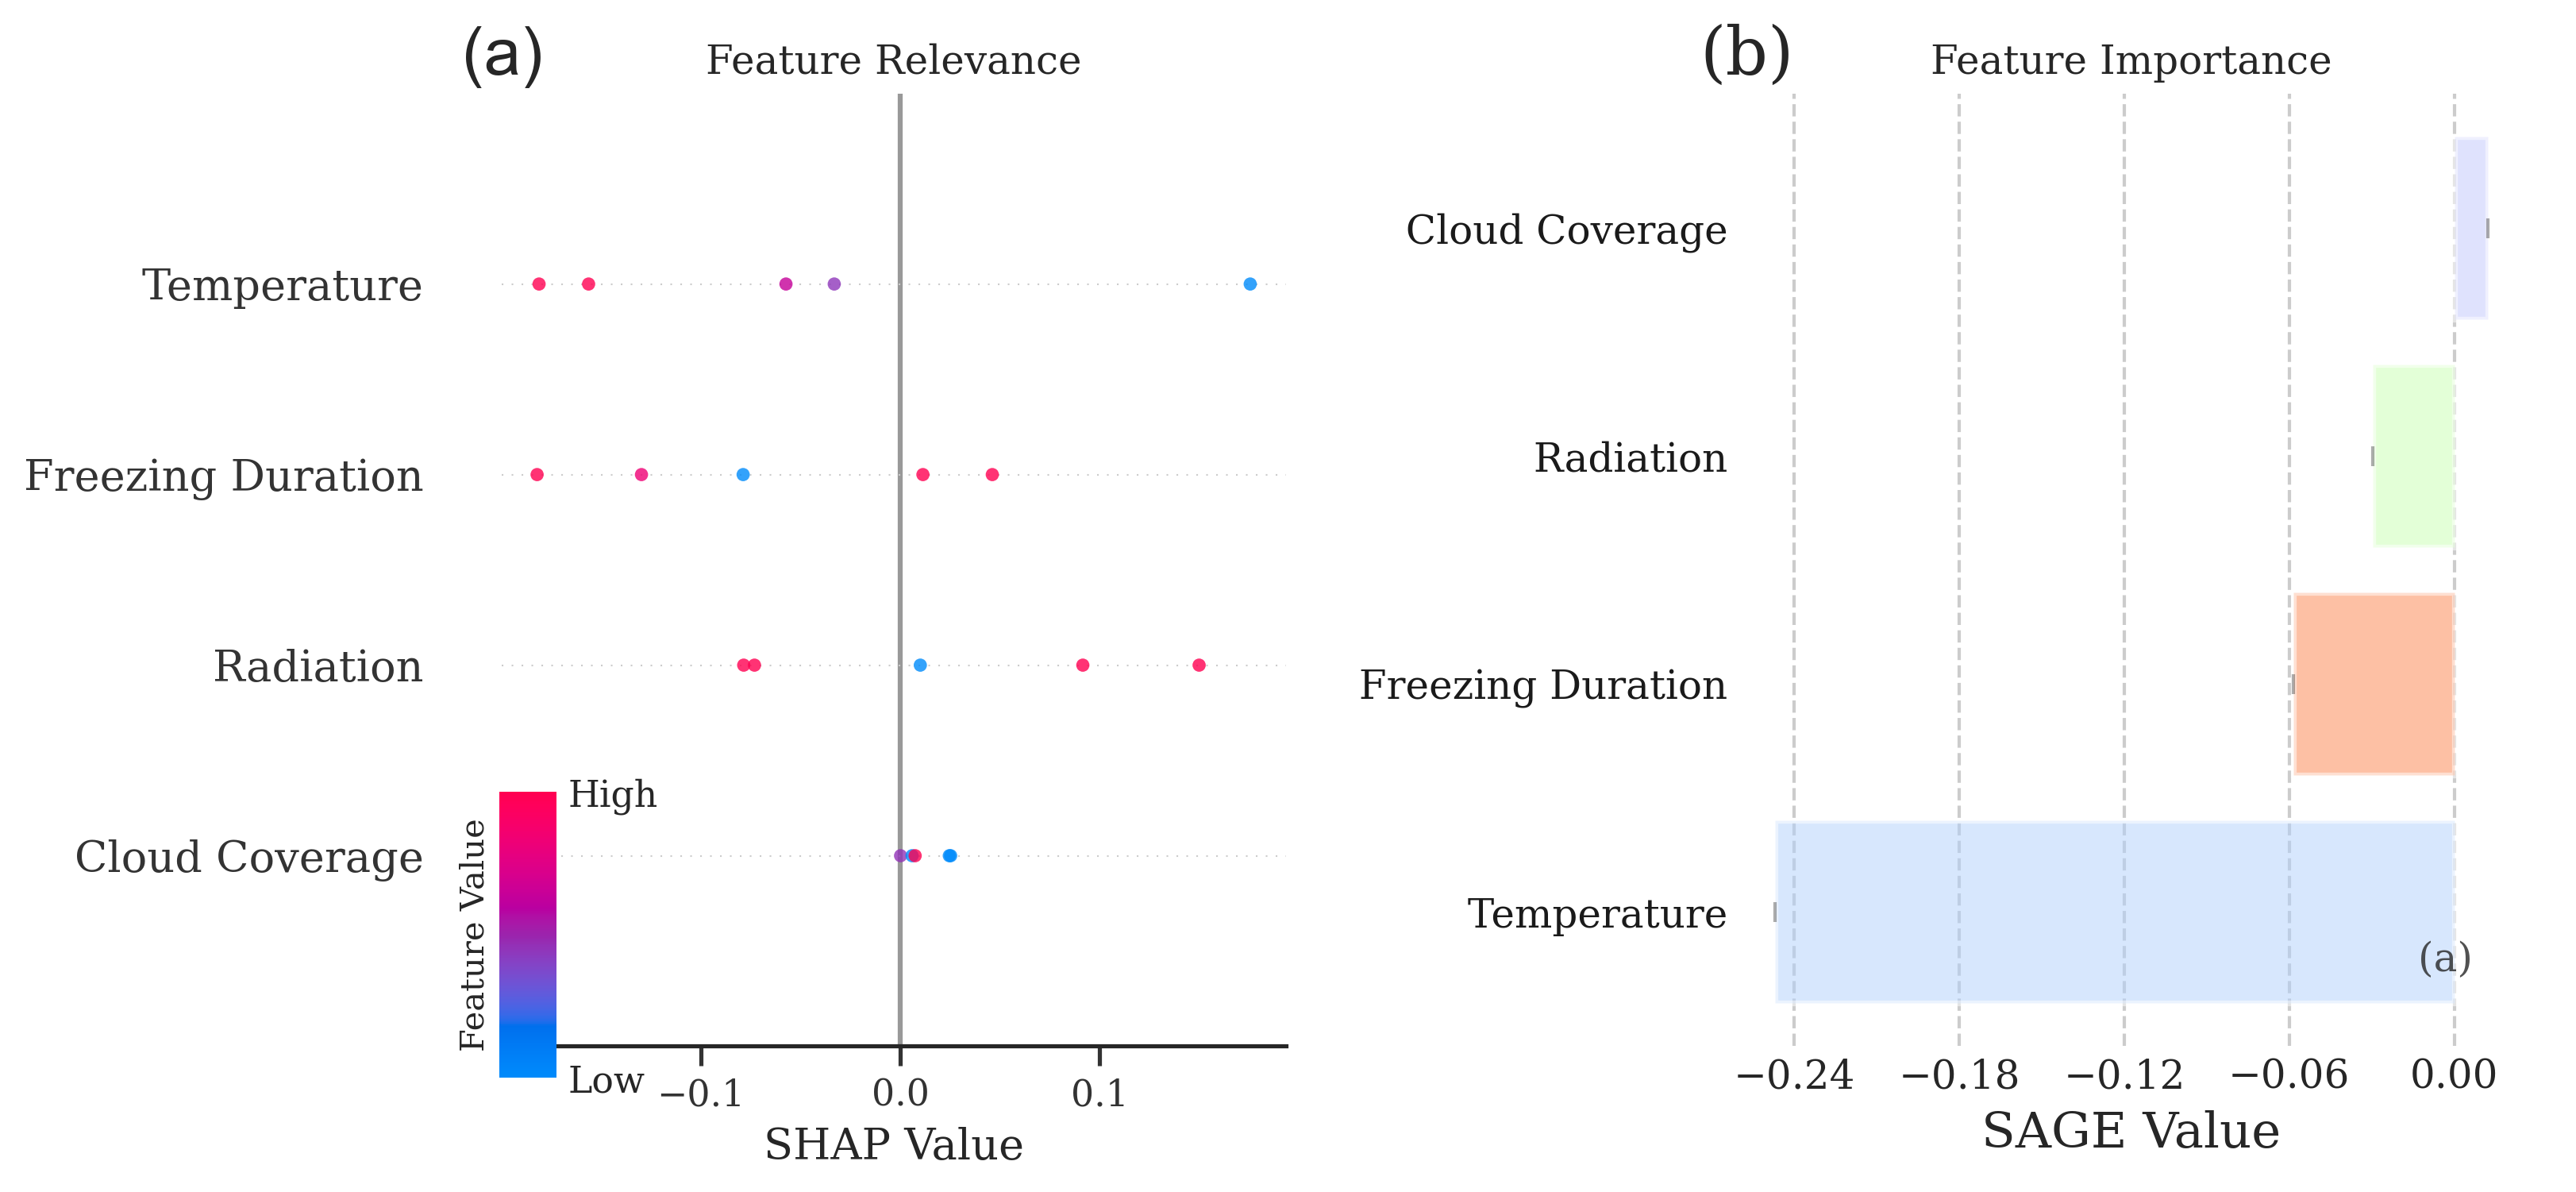

In [12]:
fig, axes = plt.subplots(dpi=300, ncols=2, figsize=(12,6))

# Group SHAP values and the feature values. Grouping the feature values involves normalizing them first. 
inds=None
X_grouped = group_feature_values(X, groups, inds, func=np.max)
grouped_shap_ds = group_local_values(shap_ds, groups, X_grouped, inds)

explainer = skexplain.ExplainToolkit(X=X_grouped)
sage_rank = explainer.load(os.path.join(RESULTS_PATH, f'grouped_sage_{DATASET}.nc'))

# Rank the grouped SHAP values by the mean absolute value. 
est_name = model[0]
vals = grouped_shap_ds[f'shap_values__{est_name}'].values
order = np.argsort(np.mean(np.absolute(vals), axis=0))[::-1]

# Left panel: SHAP 
ax, color = explainer.scatter_plot(plot_type='summary', 
                       dataset=grouped_shap_ds, 
                       estimator_name=model[0], method='shap',
                       order=order, 
                       display_feature_names=display_feature_names,
                       ax=axes[0],
                       fig=fig,
                       add_colorbar=False,
                       max_display=len(X)
                      )
ax.set_xlabel('SHAP Value')
ax.set_title('Feature Relevance', fontsize=12)
ax.annotate('(a)', (-0.05, 1.02), xycoords='axes fraction', fontsize=20)

# Right panel: SAGE
data = [sage_rank]
panels = [ ('sage', est_name)]
explainer.plot_importance(data=data, panels=panels, 
                                num_vars_to_plot=len(X), 
                                feature_colors=feature_colors,
                                display_feature_names=display_feature_names,
                                n_columns=1,
                                base_font_size= 17,
                                alphabet_fontsize=12, 
                                rho_threshold=0.7,
                                xlabels=['SAGE Value'],
                                ax=axes[1], 
                               )
axes[1].xaxis.grid(ls='dashed')
axes[1].set_title('Feature Importance', fontsize=12)
axes[1].annotate('(b)', (-0.05, 1.02), xycoords='axes fraction', fontsize=20)

# Add colorbar to the left panel for the normalized feature value range. 
cb = add_summary_plot_cb(color, cax=axes[0], orientation='vertical', 
                        fig=fig, ax_dim=[0.25, 0.2, 0.02, 0.2], fontsize=10, 
                         labelpad=-60, y = 0.5,
                        )


#### Learned Feature Effects with ALE, SHAP, and conditional base rates 

The learned effect plots in the figure below are dense but include multiple useful details:

    * Black curve: Average first-order effect as measured by the ALE method,
    * Scatter points: SHAP values as a function of a feature's value,
    * Dashed red curve: centered conditional base rate measured by a Bayesian histogram method 
    * Rug plot on the bottom: indicates the approximate distribution of the feature values

By combining the ALE curve with SHAP dependence plots, we can better understand how changes in a feature's value affect the model predictions on average and for specific examples. For instance, the ALE curve highlights the average first-order effect, while the vertical dispersion of SHAP values for a specific feature value reveals the impact of higher-order effects. The scatter points are color-coded based on the values of one of the most important feature, which helps identify potential feature interactions. We assume that relevant higher-order effects stem from the most relevant first-order effects as per the strong effect heredity principle (CITATION). To estimate the strongest interaction with the most important feature, we bin its SHAP values by the feature values of all other features and use the feature with the highest linear correlation coefficient.  Potential interaction effects should be interpreted cautiously, as some may be spurious compensation effects (e.g., probabilities cannot exceed 1) or due to feature correlations, as shown below.

Although we display the top 6 important features, we encourage the reader to explore other features. You change what features are plotted by setting the `features` variable below. 



In [13]:
# The interaction index for each dataset is set here. 

interaction_index= {'road_surface' : 'sfc_temp', 
                    'lightning' : 'q100_vl',
                    'severe_wind' : 'ws_80__time_max__amp_ens_mean_spatial_perc_90'
                   }

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

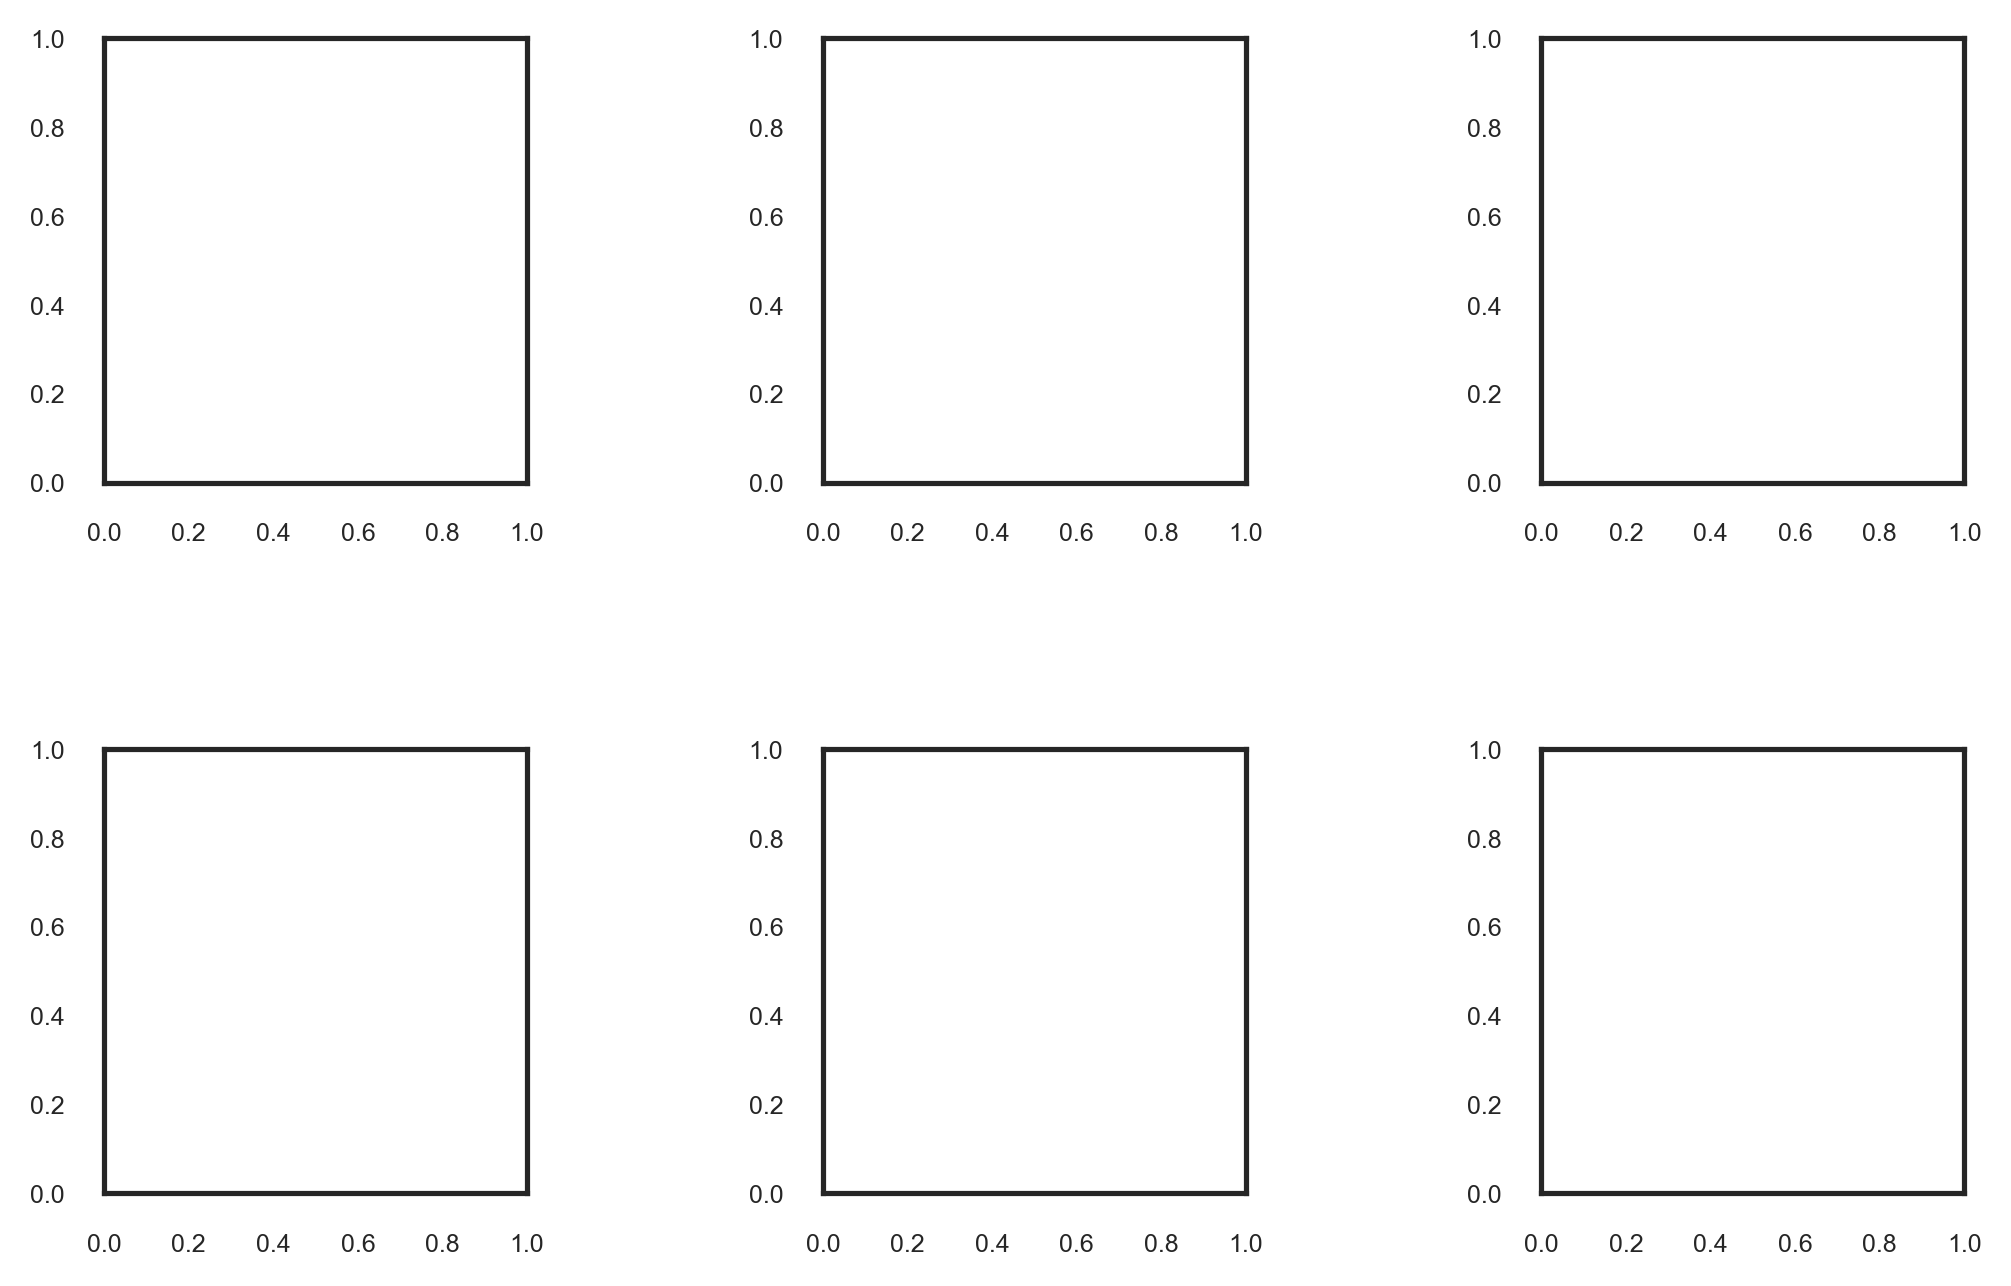

In [16]:
plotter= PlotStructure(BASE_FONT_SIZE = 16)

explainer = skexplain.ExplainToolkit(X=X)
rank = explainer.load(os.path.join(RESULTS_PATH, f'sage_{DATASET}.nc'))
features = list(rank[f'sage_rankings__{model[0]}'].values[:6]) 
vals_df = pd.DataFrame(shap_ds[f'shap_values__{model[0]}'].values, columns=shap_ds.attrs['features'])

ylabel = 'SHAP Value'

histdata=X.copy()
histdata['target'] = y
fig, axes = explainer.scatter_plot(
                    plot_type = 'dependence',
                    features=features,
                    dataset = shap_ds,
                    method = 'shap',
                    estimator_name = model[0],
                    display_feature_names=display_feature_names,
                    display_units = display_units,
                    interaction_index=interaction_index[DATASET],
                    orientation = 'horizontal',
                    ylabel = ylabel,

        )  


# Compute the Bayes-derived event rate
for f, ax in zip(features, axes.flat):
    ax_twin = plotter.make_twin_ax(ax)
    ax_twin.set_zorder(ax.get_zorder() + 1)
    ax_twin.patch.set_visible(False)
    ax.patch.set_visible(False)
    sns.despine(ax=ax_twin)
    for spine in ax_twin.spines.values():
        spine.set_edgecolor('k')
    
    data = X[f].values.astype(float)
    bin_edges, beta_dist = bayesian_histogram(data, y)
    base_rate = beta_dist.median()#*100.
    centered_base_rate = base_rate-np.mean(base_rate)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    ax_twin.tick_params(colors='xkcd:rouge')
    
    plot_bayesian_histogram(bin_edges, beta_dist, ax=ax_twin, color = 'xkcd:rouge', label='Event Rate')
    
    ax.plot(ale_data[f'{f}__bin_values'], 
                    ale_data[f'{f}__{model[0]}__ale'].values[0], color='k', lw=2.0, 
                   label='ALE')
    
    # Add rug plot.
    sns.rugplot(data=X, x=f, ax=ax, lw=0.75, alpha=0.002, height=0.07, color='k')
    
major_ax = plotter.set_major_axis_labels(fig, 
                              xlabel=None, 
                              ylabel_right='Event Rate [P(y=1|x$_{i}$)]', title=None,
                              ylabel_right_color = 'xkcd:rouge',
                              labelpad=30, 
    )    

plt.tight_layout()

### SAGE vs. SHAP (Alternative)

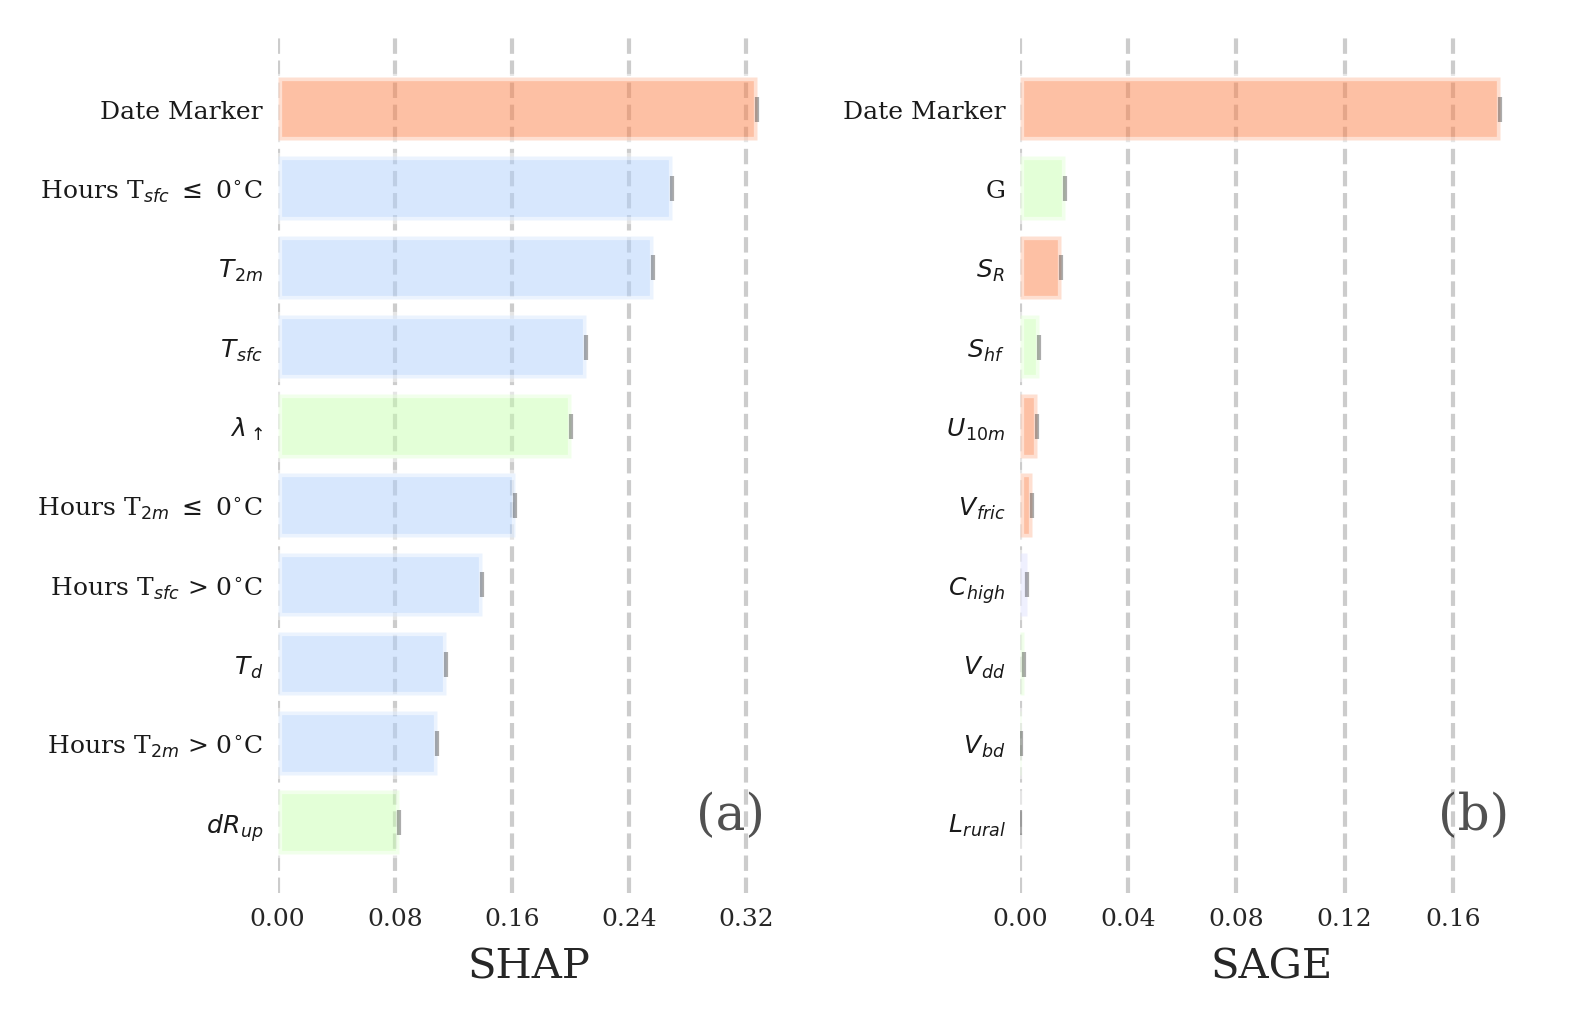

In [18]:
explainer = skexplain.ExplainToolkit()
sage_rank = explainer.load(os.path.join(RESULTS_PATH, f'sage_{DATASET}.nc'))

est_name = model[0]

vals = shap_ds[f'shap_values__{est_name}'].values

shap_rank = to_skexplain_importance(vals, 
                                     estimator_name=est_name, 
                                     feature_names=list(shap_ds.attrs['features']), 
                                     method ='shap_sum', 
                                     normalize=False    
                                       )

data = [shap_rank, sage_rank]
panels = [('shap_sum', est_name), ('sage', est_name)]

xlabels=['SHAP', 'SAGE']
fig, axes = explainer.plot_importance(data=data, panels=panels, 
                                num_vars_to_plot=10, 
                                feature_colors=feature_colors,
                                display_feature_names=display_feature_names,
                                figsize=(6,4), 
                                n_columns=2,
                                xlabels=xlabels,
                                base_font_size= 12,
                                alphabet_fontsize=12, 
                                rho_threshold=0.7,
                                 
                               )
for ax in axes.flat:
    ax.xaxis.grid(ls='dashed')
    ax.set_title('')
    
plt.tight_layout()